# Reduced-rank regression analysis

In [1]:
# Prepare
import numpy as np
import pylab as plt
import seaborn as sns; sns.set()
import pandas as pd
import matplotlib
import pickle
import scipy
import time
import warnings

import rnaseqTools

# pip install glmnet_py
import sparseRRR

def sns_styleset():
    sns.set(context='paper', style='ticks')
    matplotlib.rcParams['axes.linewidth']    = .5
    matplotlib.rcParams['xtick.major.width'] = .5
    matplotlib.rcParams['ytick.major.width'] = .5
    matplotlib.rcParams['xtick.major.size'] = 2
    matplotlib.rcParams['ytick.major.size'] = 2
    matplotlib.rcParams['xtick.minor.size'] = 1
    matplotlib.rcParams['ytick.minor.size'] = 1
    matplotlib.rcParams['font.size']       = 6
    matplotlib.rcParams['axes.titlesize']  = 6
    matplotlib.rcParams['axes.labelsize']  = 6
    matplotlib.rcParams['legend.fontsize'] = 6
    matplotlib.rcParams['xtick.labelsize'] = 6
    matplotlib.rcParams['ytick.labelsize'] = 6
    matplotlib.rcParams['figure.dpi'] = 120

sns_styleset()

def adjustlabels(fig, labels, max_iter=1000, eps=0.01, delta=0.1, 
                 clip_to_axes=True, pad=0.1):
    N = len(labels)
    widths = np.zeros(N)
    heights = np.zeros(N)
    centers = np.zeros((N, 2))
    for i,l in enumerate(labels):
        bb = l.get_window_extent(renderer=fig.canvas.get_renderer())
        bb = bb.transformed(plt.gca().transData.inverted())
        widths[i] = bb.width
        heights[i] = bb.height
        centers[i] = (bb.min + bb.max)/2
        
    ylim = plt.gca().get_ylim()
    xlim = plt.gca().get_xlim()    

    def clip():
        for i in range(N):
            centers[i,0] = max(centers[i,0], xlim[0] + widths[i]/2 + pad)
            centers[i,0] = min(centers[i,0], xlim[1] - widths[i]/2 - pad)
            centers[i,1] = max(centers[i,1], ylim[0] + heights[i]/2 + pad)
            centers[i,1] = min(centers[i,1], ylim[1] - heights[i]/2 - pad)
            labels[i].set_position(centers[i])
    clip()

    for i in range(max_iter):
        stop = True
        for a in range(N):
            for b in range(N):
                if ((a!=b) and
                    (np.abs(centers[a,0]-centers[b,0]) < (widths[a]+widths[b])/2 + delta) and
                    (np.abs(centers[a,1]-centers[b,1]) < (heights[a]+heights[b])/2 +  delta)):
                    
                    d = centers[a] - centers[b]
                    centers[a] += d * eps
                    centers[b] -= d * eps
                    labels[a].set_position(centers[a])
                    labels[b].set_position(centers[b])
                    if clip_to_axes:
                        clip()
                    stop = False
        if stop:
            break    

In [2]:
from collections import namedtuple
cnData = namedtuple('cnData', 'exonCounts cells genes\
                                         t_cluster\
                                         ephys ephysNames \
                                         morphometrics morphometricsNames\
                                         cellcolor')


cn = pickle.load(open('cn_exn.pickle', 'rb'))



clusterColors = cn.cellcolor
clusterNames = cn.t_cluster
clusterN = clusterNames.size

/tmp/ipykernel_2878177/2586439312.py:9: DeprecationWarning: Please use `csr_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csr` namespace is deprecated.
  cn = pickle.load(open('/media/data2/samba/jz/RRR_analysis/cn_exn.pickle', 'rb'))


In [3]:
features_exclude = ['Holding (pA)', 'Step Increase (pA)',
       'First Current Injection (pA)','AP2_Diff', 'AP3_Diff',
       'AP_End_Diff', 'Rebound_abs (mV)', 'Rebound_spikes',
       'epsc_rise_time (ms)','epsc_half_width (ms)', 'epsc_decay_tau (ms)', 'epsc_freq (Hz)',
       'epsc_amp (pA)', 'ipsc_rise_time (ms)', 'ipsc_half_width (ms)','Spike_Delay @ 2xRheobase',
       'ipsc_decay_tau (ms)', 'ipsc_freq (Hz)', 'ipsc_amp (pA)','AP Number @ 2xRheabase',
                    'Initial Adaptation', 'Last Adaptation',]

ephysY = cn.ephys.copy()
ephysY = ephysY[:, ~np.isin(cn.ephysNames, features_exclude)]
print(ephysY.shape)

(326, 14)


Chosen offset: 7.40


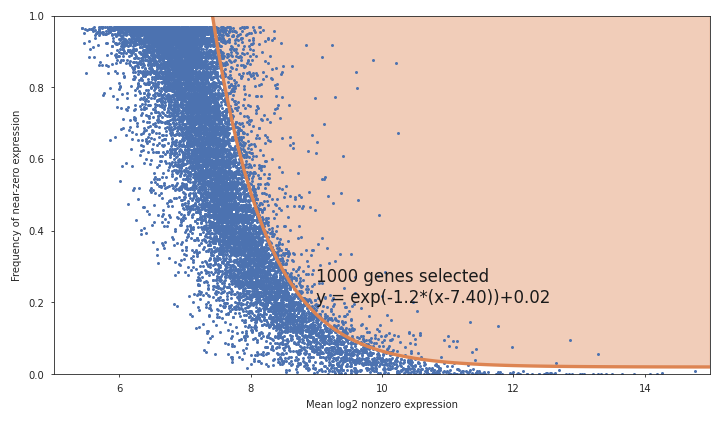

In [4]:
genesForRRR  = rnaseqTools.geneSelection(cn.exonCounts, n=1000, threshold=32, decay=1.2)

In [5]:
X =  cn.exonCounts#[selection,:] / m1.exonLengths
#X += m1.intronCounts[selection,:] / (m1.intronLengths + 0.001)
X /= np.sum(X, axis=1)
X *= 1e+6
X = X.A[:, genesForRRR]

X = np.array(X)
X = np.log2(X + 1)
X = X - np.mean(X, axis=0)
X = X / np.std(X, axis=0)

Y = ephysY - np.mean(ephysY, axis=0)
Y = Y / np.std(Y, axis=0)

print('Shape of X:', X.shape, '\nShape of Y:', Y.shape)

Shape of X: (326, 1000) 
Shape of Y: (326, 14)


In [6]:
w,v = sparseRRR.relaxed_elastic_rrr(X, Y, rank=5, lambdau=.51, alpha=1)

print(cn.genes[genesForRRR][np.where(w[:,0]!=0)[0]])
print(np.sum(w[:,0]!=0))

['Cryba2' 'Rgs4' 'Ass1' 'Lamp5' 'Ptprt' 'Phgdh' 'Ndst4' 'Tpm2' 'Lgi2'
 'Tmem132c' 'Kcnd2' 'Dkk3' 'Cx3cl1' 'Calb2' 'Utrn' 'Plk5' 'Syt1' 'Kcnc2'
 'Tafa2' 'Plxdc1' 'Tspan10' 'Rgs6' 'Dlg1' 'Pcp4' 'Fgf13']
25


In [7]:
lambdas = np.array([.51])
alphas = np.array([1])
r2, r2_relaxed, nonzero, corrs, corrs_relaxed = sparseRRR.elastic_rrr_cv(
    X, Y, rank=5, reps=1, folds=10, alphas=alphas, lambdas=lambdas)

print('R2: {:.2f}, corrs: {:.2f}, {:.2f}, {:.2f}, {:.2f}, {:.2f}'.format(
    np.mean(r2_relaxed), *np.mean(corrs_relaxed,axis=0).squeeze()))

1.......... Time: 0.0h  0m  1s
R2: 0.41, corrs: 0.87, 0.79, 0.68, 0.51, 0.54


In [8]:
shortEphysLabels = {'Tau (ms)': 'Tau',
                    'SagRatio': 'Sag',
                    'Rebound (mV)': 'Rebound',
                    'RM (Mohm)': 'RM',
                    'RMP (mV)': 'RMP',
                    'RheoBase (pA)': 'Rheobase',
                    'Spike Delay (ms)': 'Delay',
                    'Threshold (mV)': 'Threshold',
                    'Amplitude (mV)': 'Amp',
                    'AHP (mV)': 'AHP',
                    'Depolarization Time (ms)': 'Depo time',
                    'Repolarization Time (ms)': 'Repo time',
                    'Half Width (ms)': 'Half Width',
                    'Max Spike Number': 'Max spikes'}

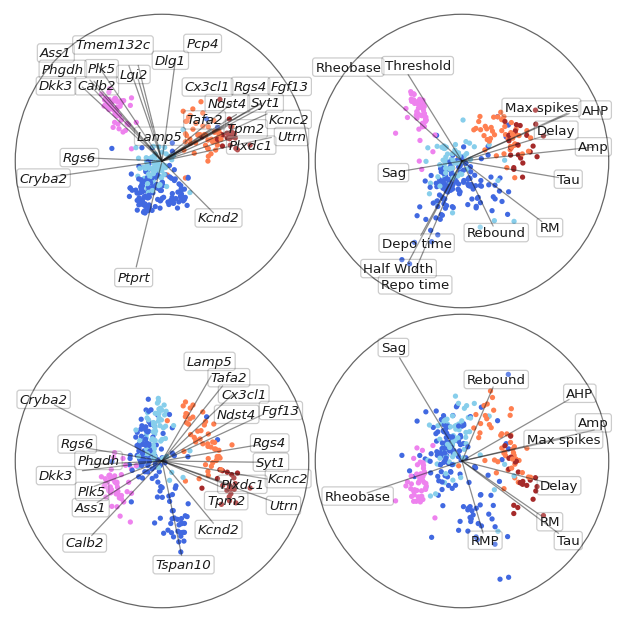

In [9]:
fig = plt.figure(figsize=(5, 5))

L = 4.6
scaleFactor = 4.5
s = 10
width = .5
col = clusterColors
labelslabels = [cn.genes[genesForRRR], 
                [shortEphysLabels[e] for e in cn.ephysNames if e not in features_exclude]]

for row, components in enumerate([[0,1],[0,2]]):
    
    Zx = X @ w[:,components]
    Zy = Y @ v[:,components]
    Zx = Zx / np.std(Zx, axis=0)
    Zy = Zy / np.std(Zy, axis=0)

    for column, (Z,F,wv,labels) in enumerate(zip([Zx,Zy], [X,Y], [w,v],labelslabels)):
        plt.axes([column*width+(1-2*width)/2, .5-row*width, width, width])
        plt.scatter(Z[:,0], Z[:,1], c=col,s=s, edgecolors='none')
        plt.xticks([])
        plt.yticks([])
        plt.xlim([-L,L])
        plt.ylim([-L,L])
        Rho = np.corrcoef(np.concatenate((Z[:,:2], F), axis=1), rowvar=False)[2:,:2]
        shownlabels = []
        for i in np.where(wv[:,0]!=0)[0]:
            if np.sqrt(np.sum(Rho[i,:]**2)) > .4:
                plt.plot([0, scaleFactor*Rho[i,0]], [0, scaleFactor*Rho[i,1]],alpha = 0.5, 
                         linewidth=.75, color='k', zorder=1)
                if column == 0:
                    l = plt.text(scaleFactor*Rho[i,0]*1.1, scaleFactor*Rho[i,1]*1.1, labels[i],
                         ha='center', va='center', color='k', fontsize=8, zorder=10,style='italic',fontweight = 550,
                       bbox=dict(facecolor=(1,1,1,0.2), edgecolor=(0,0,0,0.2), boxstyle='round', linewidth=.75, pad=.2)
                                )
                    shownlabels.append(l)
                else:
    
                    l = plt.text(scaleFactor*Rho[i,0]*1.1, scaleFactor*Rho[i,1]*1.1, labels[i],fontweight = 550,
                         ha='center', va='center', color='k', fontsize=8, zorder=10,
                      bbox=dict(facecolor=(1,1,1,0.2), edgecolor=(0,0,0,0.2), boxstyle='round', linewidth=.75, pad=.2)
                                )
                    shownlabels.append(l)                    
        adjustlabels(fig, shownlabels)
        circ = plt.Circle((0,0), radius=scaleFactor, color=[.4, .4, .4], fill=False, linewidth=.75, zorder=-1)
        plt.gca().add_patch(circ)

sns.despine(left=True, bottom=True)

## Boostrap gene selection

In [10]:

w,v = sparseRRR.relaxed_elastic_rrr(X, Y, rank=5, lambdau=.51, alpha=1)

bootCounts = sparseRRR.elastic_rrr_bootstrap(X, Y, rank=5, lambdau=.51, alpha=1, nrep=100)

.................................................................................................... 


In [11]:
args = np.argsort(bootCounts)[::-1]
for i in range(25):
    print('{:10} {:.2f}'.format(cn.genes[genesForRRR][args[i]],
                                bootCounts[args[i]]), end='')
    if ~np.isclose(w[args[i],0],0):
        print('  *')
    else:
        print('')

Cryba2     1.00  *
Ass1       0.99  *
Fgf13      0.95  *
Kcnc2      0.94  *
Utrn       0.93  *
Calb2      0.93  *
Pcp4       0.90  *
Ndst4      0.86  *
Rgs6       0.85  *
Dkk3       0.82  *
Ptprt      0.81  *
Tspan10    0.78  *
Lamp5      0.75  *
Phgdh      0.72  *
Cx3cl1     0.69  *
Tmem132c   0.60  *
Plk5       0.58  *
Dlg1       0.53  *
Syt1       0.50  *
Kcnd2      0.48  *
Rasgrf1    0.44
Tpm2       0.44  *
Stxbp2     0.41
Tafa2      0.38  *
Lgi2       0.36  *


In [13]:
lambdas = np.array([.5])
alphas = np.array([1])

r2, r2_relaxed, nonzero, corrs, corrs_relaxed = sparseRRR.elastic_rrr_cv(
    X, Y, rank=5, reps=1, folds=10, alphas=alphas, lambdas=lambdas)

print('R2: {:.2f}, corrs: {:.2f}, {:.2f}, {:.2f}, {:.2f}, {:.2f}'.format(
    np.mean(r2_relaxed), *np.mean(corrs_relaxed,axis=0).squeeze()))

1.......... Time: 0.0h  0m  1s
R2: 0.41, corrs: 0.87, 0.78, 0.67, 0.53, 0.53


In [16]:
%%time

lambdas = np.concatenate((np.arange(.2,1.01,.1), np.arange(2,7)))
alphas = np.array([.5, .75, 1])

cvresults = sparseRRR.elastic_rrr_cv(X, Y, rank=5, reps=1, folds=10, alphas=alphas, lambdas=lambdas)

lambdas = np.arange(.2,1,.1)
alphas = np.array([1])
ranks = np.arange(1, Y.shape[1]+1)

cvresults_rank = {}
for r in ranks:
    cvresults_rank[r] = sparseRRR.elastic_rrr_cv(X, Y, rank=r, reps=1, folds=10, alphas=alphas, lambdas=lambdas)

1.......... Time: 0.0h  1m  4s
1.......... Time: 0.0h  0m  4s
1.......... Time: 0.0h  0m  6s
1.......... Time: 0.0h  0m 10s
1.......... Time: 0.0h  0m 13s
1.......... Time: 0.0h  0m 10s
1.......... Time: 0.0h  0m 29s
1.......... Time: 0.0h  0m 21s
1.......... Time: 0.0h  0m 33s
1.......... Time: 0.0h  0m 31s
1.......... Time: 0.0h  0m 42s
1.......... Time: 0.0h  0m 32s
1.......... Time: 0.0h  0m 47s
1.......... Time: 0.0h  0m 17s
1.......... Time: 0.0h  0m  9s
CPU times: user 1h 12min 3s, sys: 4h 38min 16s, total: 5h 50min 20s
Wall time: 6min 6s


In [17]:
pickle.dump([cvresults, cvresults_rank], open('cvresults_new.pickle', 'wb'))

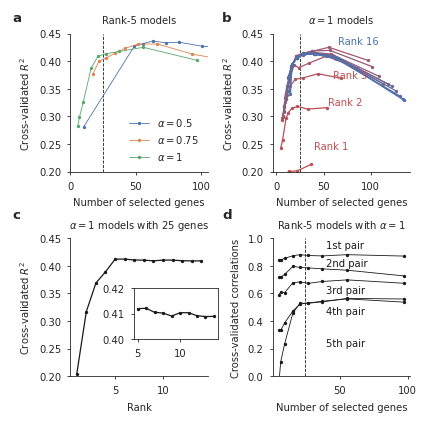

In [32]:
#cvresults, cvresults_rank = pickle.load(open('cvresults.pickle', 'rb'))

r2, r2_relaxed, nonzeros, corrs, corrs_relaxed = cvresults
with warnings.catch_warnings():
    warnings.simplefilter('ignore', category=RuntimeWarning)
    nonzeros = np.nanmean(nonzeros, axis=(0,1))
    r2_relaxed = np.nanmean(r2_relaxed, axis=(0,1))
    r2 = np.nanmean(r2, axis=(0,1))
    corrs_relaxed = np.nanmean(corrs_relaxed, axis=(0,1))

fig = plt.figure(figsize=(3.5, 3.5))
plt.subplot(221)
plt.plot(nonzeros, r2_relaxed, '.-', linewidth=.5, markersize=2)
plt.gca().set_prop_cycle(None)
#plt.plot(nonzeros, r2, '.--', linewidth=.5, alpha=.5, markersize=2)
plt.xlabel('Number of selected genes')
plt.ylabel('Cross-validated $R^2$')
plt.ylim([.2,.45])
plt.legend(['$\\alpha='+str(a)+'$' for a in [.5, .75, 1]], frameon=False)
plt.plot([25,25],[.2,.45],'k--', linewidth=.5, zorder=0)
plt.title('Rank-5 models')
plt.xlim([0,105])
# plt.text(100, .36, 'Naive', color='k', fontsize=6)
# plt.text(35, .42, 'Relaxed', color='k', fontsize=6)

plt.subplot(224)
for k in range(corrs_relaxed.shape[2]):
    plt.plot(nonzeros[:,2], corrs_relaxed[:,2,k].squeeze(), 'k.-', linewidth=.5, markersize=2)
plt.xlabel('Number of selected genes')
plt.ylabel('Cross-validated correlations')
plt.ylim([0,1])
plt.title(r'Rank-5 models with $\alpha=1$')
plt.plot([25,25],[0,1],'k--', linewidth=.5, zorder=0)
for i,c in zip(['1st','2nd','3rd','4th','5th'], [.93,.8,.6,.45,.22]):
    plt.text(40, c, '{} pair'.format(i), color='k', fontsize=6)

plt.subplot(222)
maxRank = len(cvresults_rank)
colA = np.array([76, 114, 176]) / 256
colB = np.array([196, 78, 82])  / 256
perf25 = np.zeros(maxRank+1)
for rank in range(1,maxRank+1):
    with warnings.catch_warnings():
        warnings.simplefilter('ignore', category=RuntimeWarning)
        n = np.nanmean(cvresults_rank[rank][2], axis=(0,1))
        c = np.nanmean(cvresults_rank[rank][0], axis=(0,1))
        cr = np.nanmean(cvresults_rank[rank][1], axis=(0,1))
        f = scipy.interpolate.interp1d(n.squeeze(), cr.squeeze(), kind='linear')
        perf25[rank] = f(25)
    col = (colA * (rank-1)/(maxRank-1) + colB * (maxRank-rank)/(maxRank-1))
    plt.plot(n[:,0], cr[:,0], '.-', color=col, linewidth=.75, markersize=2)
plt.ylim([.2,.45])
plt.xlabel('Number of selected genes')
plt.ylabel('Cross-validated $R^2$')
plt.plot([25,25],[.2,.45],'k--', linewidth=.5, zorder=0)
plt.text(40, .24, 'Rank 1', color=colB, fontsize=6)
plt.text(55, .32, 'Rank 2', color=colB, fontsize=6)
plt.text(60, .37, 'Rank 3', color=colB, fontsize=6)
plt.text(65, .43, 'Rank 16', color=colA, fontsize=6)
plt.title(r'$\alpha=1$ models')

plt.subplot(223)
plt.plot(np.arange(1,maxRank+1), perf25[1:], 'k.-', linewidth=.75, markersize=2)
plt.xlabel('Rank')
plt.ylabel('Cross-validated $R^2$')
plt.ylim([.2,.45])
plt.title(r'$\alpha=1$ models with 25 genes')

sns.despine()
plt.tight_layout()

ax = plt.axes([.3,.2,.2,.12])
plt.plot(np.arange(5,maxRank+1), perf25[5:], 'k.-', linewidth=.75, markersize=2)
plt.ylim([0.40,0.42])

fig.text(.01, .98,  'a', fontsize=8, fontweight='bold', va='top')
fig.text(.51, .98,  'b', fontsize=8, fontweight='bold', va='top')
fig.text(.01, .51,  'c', fontsize=8, fontweight='bold', va='top')
fig.text(.51, .51,  'd', fontsize=8, fontweight='bold', va='top')

plt.savefig('/media/data2/samba/jz/rrr-cv.pdf', dpi=300)

# Ion channel genes only

In [12]:
import pandas as pd
ionchannelgenes = pd.read_csv('ion_channels.csv')['Approved symbol'].values
print(ionchannelgenes.size)

#selection = ~np.isnan(np.sum(ephysY, axis=1)) & (cn.exclude=='') & (ttypes['type']!='')

genesForRRR = np.array([m.upper() in ionchannelgenes for m in cn.genes]) & \
              np.array((np.sum(cn.exonCounts>0,axis=0)>=10)).squeeze()

X =  cn.exonCounts#[selection,:] / cn.exonLengths
#X += cn.intronCounts[selection,:] / (cn.intronLengths + 0.001)
X /= np.sum(X, axis=1)
X *= 1e+6
X = X.A[:, genesForRRR]

X = np.array(X)
X = np.log2(X + 1)
X = X - np.mean(X, axis=0)
X = X / np.std(X, axis=0)


Y = ephysY - np.mean(ephysY, axis=0)
Y = Y / np.std(Y, axis=0)

print('Shape of X:', X.shape, '\nShape of Y:', Y.shape)

123
Shape of X: (326, 103) 
Shape of Y: (326, 14)


In [13]:
w,v = sparseRRR.relaxed_elastic_rrr(X, Y, rank=5, lambdau=.272, alpha=1)

print(cn.genes[genesForRRR][np.where(w[:,0]!=0)[0]])
print(np.sum(w[:,0]!=0))

['Kcnb2' 'Cacna1e' 'Kcnj9' 'Kcnh1' 'Scn3a' 'Kcna4' 'Kcnd3' 'Kcnq4'
 'Cacna2d1' 'Kcnk3' 'Kcnd2' 'Cacna2d4' 'Kcna1' 'Kcna6' 'Kcng4' 'Scn4b'
 'Kcnc2' 'Kcns3' 'Kcnh5' 'Kcnk10' 'Hcn1' 'Cacna2d3' 'Nalcn' 'Cacna1h'
 'Kcnh8']
25


In [14]:
lambdas = np.array([.272])
alphas = np.array([1])
r2, r2_relaxed, nonzero, corrs, corrs_relaxed = sparseRRR.elastic_rrr_cv(
    X, Y, rank=5, reps=1, folds=10, alphas=alphas, lambdas=lambdas)

print('R2: {:.2f}, corrs: {:.2f}, {:.2f}, {:.2f}, {:.2f}, {:.2f}'.format(
    np.mean(r2_relaxed), *np.mean(corrs_relaxed,axis=0).squeeze()))

1.......... Time: 0.0h  0m  0s
R2: 0.33, corrs: 0.81, 0.64, 0.61, 0.44, 0.41


0
1
0
1


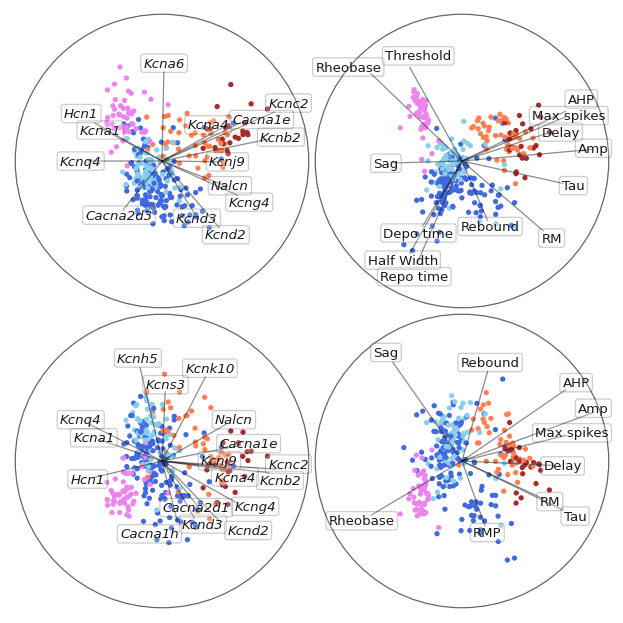

In [15]:
fig = plt.figure(figsize=(5, 5))

L = 4.6
scaleFactor = 4.5
s = 10
width = .5
col = clusterColors
labelslabels = [cn.genes[genesForRRR], 
                [shortEphysLabels[e] for e in cn.ephysNames if e not in features_exclude]]
offsets = [[{},{}],[{},{}]]

for row, components in enumerate([[0,1],[0,2]]):
    
    Zx = X @ w[:,components]
    Zy = Y @ v[:,components]
    Zx = Zx / np.std(Zx, axis=0)
    Zy = Zy / np.std(Zy, axis=0)

    for column, (Z,F,wv,labels) in enumerate(zip([Zx,Zy], [X,Y], [w,v],labelslabels)):
        print(column)
        plt.axes([column*width+(1-2*width)/2, .5-row*width, width, width])
        plt.scatter(Z[:,0], Z[:,1], c=col,s=s, edgecolors='none')
        plt.xticks([])
        plt.yticks([])
        plt.xlim([-L,L])
        plt.ylim([-L,L])
        Rho = np.corrcoef(np.concatenate((Z[:,:2], F), axis=1), rowvar=False)[2:,:2]
        #print(F)
        shownlabels = []
        for i in np.where(wv[:,0]!=0)[0]:
            if np.sqrt(np.sum(Rho[i,:]**2)) > .4:
                plt.plot([0, scaleFactor*Rho[i,0]], [0, scaleFactor*Rho[i,1]],alpha = 0.5, 
                         linewidth=.75, color='k', zorder=1)
                if column == 0:
                    l = plt.text(scaleFactor*Rho[i,0]*1.1, scaleFactor*Rho[i,1]*1.1, labels[i],
                         ha='center', va='center', color='k', fontsize=8, zorder=10,style='italic',fontweight = 550,
                       bbox=dict(facecolor=(1,1,1,0.2), edgecolor=(0,0,0,0.2), boxstyle='round', linewidth=.75, pad=.2)
                                )
                    shownlabels.append(l)
                else:
    
                    l = plt.text(scaleFactor*Rho[i,0]*1.1, scaleFactor*Rho[i,1]*1.1, labels[i],fontweight = 550,
                         ha='center', va='center', color='k', fontsize=8, zorder=10,
                      bbox=dict(facecolor=(1,1,1,0.2), edgecolor=(0,0,0,0.2), boxstyle='round', linewidth=.75, pad=.2)
                                )
                    shownlabels.append(l)                    
        adjustlabels(fig, shownlabels)
        #print(scaleFactor)
        circ = plt.Circle((0,0), radius=scaleFactor, color=[.4, .4, .4], fill=False, linewidth=.75, zorder=-1)
        plt.gca().add_patch(circ)



        
sns.despine(left=True, bottom=True)
